In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier




import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [3]:
train_df = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows= 2000000)
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train_df.shape

(2000000, 8)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 122.1+ MB


In [6]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


# EDA
* Plot Null Values
* Get "Total Distance" Colums (np.sqrt((x2-x1)^2 + (y2-y1)^2)) and Plot it
* Get "Pick up Year" and Plot it
* Plot Columns Histogram
* Plot Columns Boxplot
* Plot Columns kdeplot


In [7]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


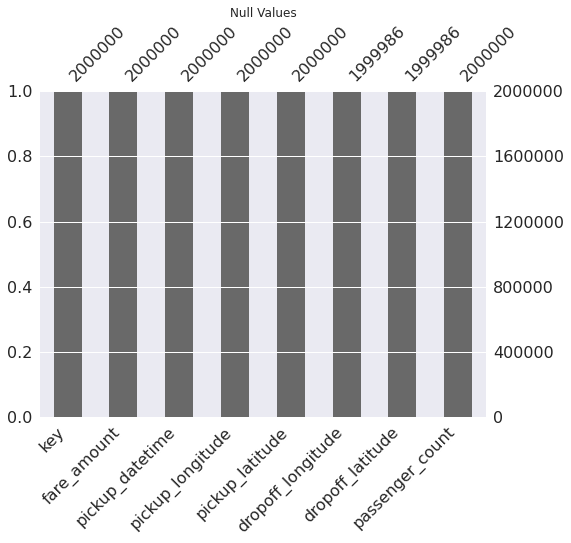

In [8]:
f, ax = plt.subplots(1,1, figsize=(8,6))
msno.bar(train_df, ax=ax)
plt.title('Null Values')
plt.show()

In [9]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

,Train Null Count
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,14
dropoff_latitude,14
passenger_count,0


In [10]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

,Test Null Count
key,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [11]:
def get_total_distance(df):
    a1 = df['pickup_longitude']
    a2 = df['dropoff_longitude']
    b1 = df['pickup_latitude']
    b2 = df['dropoff_latitude']

    return np.sqrt((a2-a1)**2 + (b2-b1)**2)

-> When you need Total Distance, Then you can use this function

In [12]:
train_df['total_distance'] = get_total_distance(train_df)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470


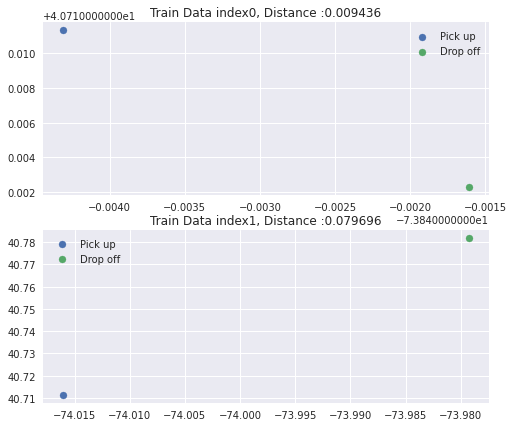

In [13]:
fig = plt.figure(figsize=(8,7))

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.title("Train Data index{}, Distance :{:f}".format(i, train_df['total_distance'][i]))
    plt.scatter(train_df['pickup_longitude'][i], train_df['pickup_latitude'][i], label="Pick up")
    plt.scatter(train_df['dropoff_longitude'][i], train_df['dropoff_latitude'][i], label="Drop off")
    plt.legend()
    
plt.show()

In [14]:
f = px.scatter_3d(train_df[:10000], x='pickup_longitude', y='dropoff_longitude', z='fare_amount',
                    color='passenger_count')
f.show()

* (pickup_longitude, dropoff_longitude) per fare_amount)

In [15]:
f = px.scatter_3d(train_df[:10000], x='dropoff_longitude', y='dropoff_latitude', z='fare_amount',
                    color='passenger_count')
f.show()

In [16]:
def get_years(df):
    return int(str(df[:4]))

In [17]:
train_df['pickup_datetime_year'] = train_df['key'].apply(lambda x: get_years(x))
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,2010


In [18]:
train_df['pickup_datetime_year'].value_counts()

2012    322587
2011    317962
2013    312548
2009    308652
2010    301338
2014    297372
2015    139541
Name: pickup_datetime_year, dtype: int64

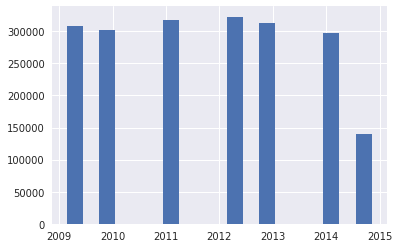

In [19]:
plt.hist(train_df['pickup_datetime_year'], rwidth=0.5)
plt.show()

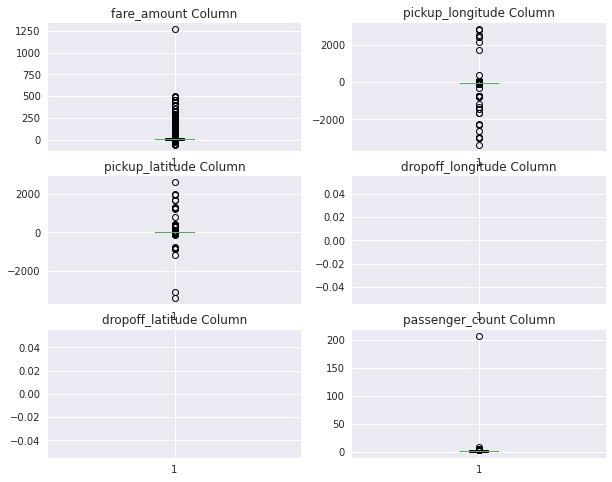

In [20]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(10,8))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.boxplot(train_df.iloc[:,i])

plt.show()

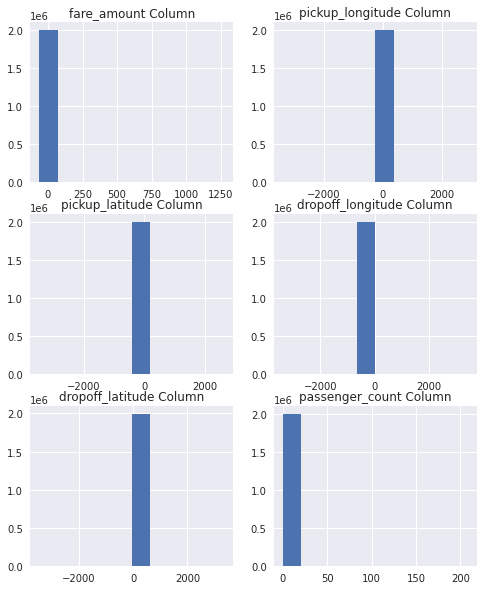

In [21]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(8,10))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    plt.hist(train_df.iloc[:,i])

plt.show()

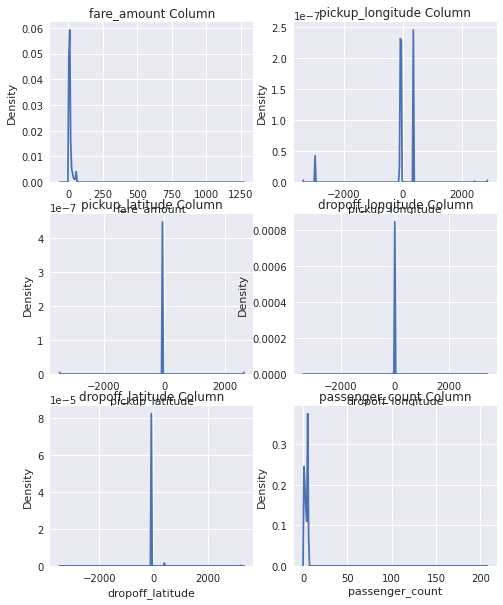

In [22]:
df_index =[1,3,4,5,6,7]
fig = plt.figure(figsize=(8,10))

for num, i in enumerate(df_index):
    plt.subplot(3,2,num+1)
    plt.title("{} Column".format(train_df.columns[i]))
    sns.kdeplot(train_df.iloc[:,i])

plt.show()

# Preprocessing
* Processing Outlier Values
* Processing Old Data

In [23]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,2010


In [24]:
def data_cleansing(df, data="Train"):
    
    print("Before cleansing shape : {}".format(df.shape))
    print("----- CLEANSING -----")
    
    if data=="Train":
        df = df.drop(df[df['fare_amount'] <= 2].index)
        df = df.drop(df[df['fare_amount'] >= 400].index)
        print(df.shape)
    
    df = df.drop(df[df['pickup_longitude'] <= -130].index)
    df = df.drop(df[df['pickup_longitude'] >= 350].index)
    print(df.shape)
   
    df = df.drop(df[df['pickup_latitude'] <= -120].index)
    df = df.drop(df[df['pickup_latitude'] >= 450].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_longitude'] <= -100].index)
    df = df.drop(df[df['dropoff_longitude'] >= 50].index)
    print(df.shape)
   
    df = df.drop(df[df['dropoff_latitude'] <= -100].index)
    df = df.drop(df[df['dropoff_latitude'] >= 100].index)
    print(df.shape)
       
    df = df.drop(df[df['passenger_count'] <= -100].index)
    df = df.drop(df[df['passenger_count'] == 0].index)
    
    print("----- CLEANSING -----")
    print("After cleansing shape : {}".format(df.shape))
    
    return df

In [25]:
train_df = data_cleansing(train_df, "Train")

Before cleansing shape : (2000000, 10)
----- CLEANSING -----
(1999835, 10)
(1999797, 10)
(1999795, 10)
(1999775, 10)
(1999760, 10)
----- CLEANSING -----
After cleansing shape : (1992637, 10)


In [26]:
test_df = data_cleansing(test_df, "Test")

Before cleansing shape : (9914, 7)
----- CLEANSING -----
(9914, 7)
(9914, 7)
(9914, 7)
(9914, 7)
----- CLEANSING -----
After cleansing shape : (9914, 7)


# Feature Engineering
* Get DateTime Type Column
* Prepocessing

In [27]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,2010


In [28]:
def get_datetime(df):
    df = str(df)
    date_0 = df.split(' ')[0]
    date_1 = df.split(' ')[1].split(":")[0] + ":" + df.split(' ')[1].split(":")[1]
    date = date_0 + " " + date_1
    return pd.to_datetime(date, format="%Y-%m-%d %H:%M")

In [29]:
train_df['time'] = train_df['key'].apply(lambda x: get_datetime(x))
test_df['time'] = test_df['key'].apply(lambda x: get_datetime(x))
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,total_distance,pickup_datetime_year,time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,2009,2009-06-15 17:26:00
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,2010,2010-01-05 16:52:00
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,2011,2011-08-18 00:35:00
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,2012,2012-04-21 04:30:00
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,2010,2010-03-09 07:51:00


In [30]:
train_df.drop(['key','pickup_datetime','total_distance','pickup_datetime_year'], axis=1, inplace=True)
test_df.drop(['key','pickup_datetime'], axis=1, inplace=True)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 17:26:00
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 16:52:00
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18 00:35:00
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 04:30:00
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 07:51:00


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992637 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   fare_amount        float64       
 1   pickup_longitude   float64       
 2   pickup_latitude    float64       
 3   dropoff_longitude  float64       
 4   dropoff_latitude   float64       
 5   passenger_count    int64         
 6   time               datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 121.6 MB


# Modeling
* Not yet